In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [20]:
df_train = pd.read_csv('E-Commerce_train.csv', delimiter=';')
df_test = pd.read_csv('E-Commerce_test.csv', delimiter= ';')

In [21]:
df_train

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8994,8995,D,Ship,3,1,217,3,low,F,1,4177,1
8995,8996,F,Ship,5,3,232,3,medium,M,3,4526,0
8996,8997,A,Ship,4,5,260,3,medium,F,6,4221,0
8997,8998,B,Ship,4,2,184,3,medium,F,5,5931,1


Analisis EDA.

Buscamos valores faltantes, valores duplicados, outliers.

In [22]:
df_train.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [23]:
df_train.duplicated().sum()

0

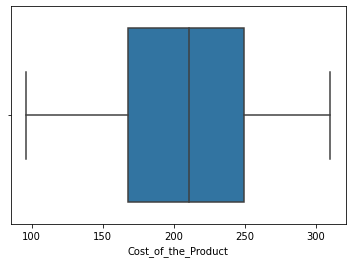

In [30]:
sns.boxplot(x= 'Cost_of_the_Product', data= df_train)
plt.show()

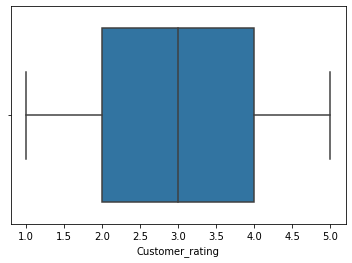

In [31]:
sns.boxplot(x= 'Customer_rating', data= df_train)
plt.show()

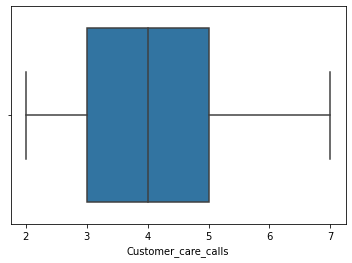

In [32]:
sns.boxplot(x= 'Customer_care_calls', data= df_train)
plt.show()

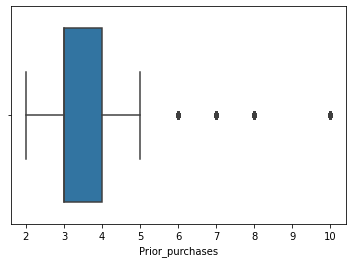

In [33]:
sns.boxplot(x= 'Prior_purchases', data= df_train)
plt.show()

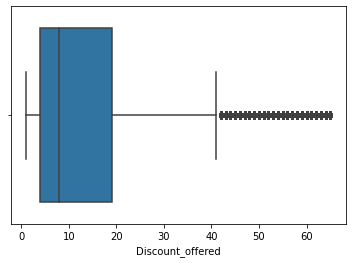

In [34]:
sns.boxplot(x= 'Discount_offered', data= df_train)
plt.show()

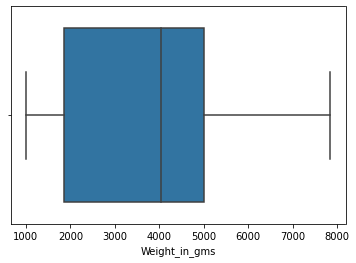

In [35]:
sns.boxplot(x= 'Weight_in_gms', data= df_train)
plt.show()

En este paso vamos a pasar al escalado y normalizado. Elegi MinMaxScaler ya que muchas de las variables numericas tienen un maximo y un minimo ya estipulado y creo que esto podria ayudar a mi modelo a predecir con mas exactitud.

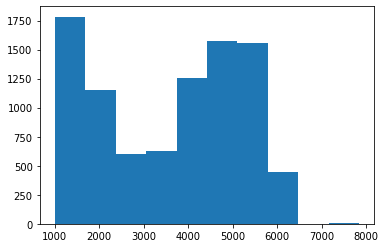

In [36]:
plt.hist(df_train['Weight_in_gms'])
plt.show()

In [39]:
scaler = MinMaxScaler()
scaler.fit(df_train[['Weight_in_gms']])
df_train['Weight_in_gms'] = scaler.transform(df_train[['Weight_in_gms']])

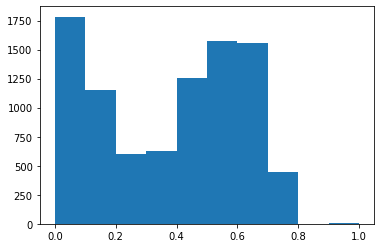

In [40]:
plt.hist(df_train['Weight_in_gms'])
plt.show()

Luego pasamos a la codificacion de las variables categoricas que nos van a servir para el modelado. Yo decidi quitar la columna de genero ya que considero que no influye en nada para el problema a resolver.

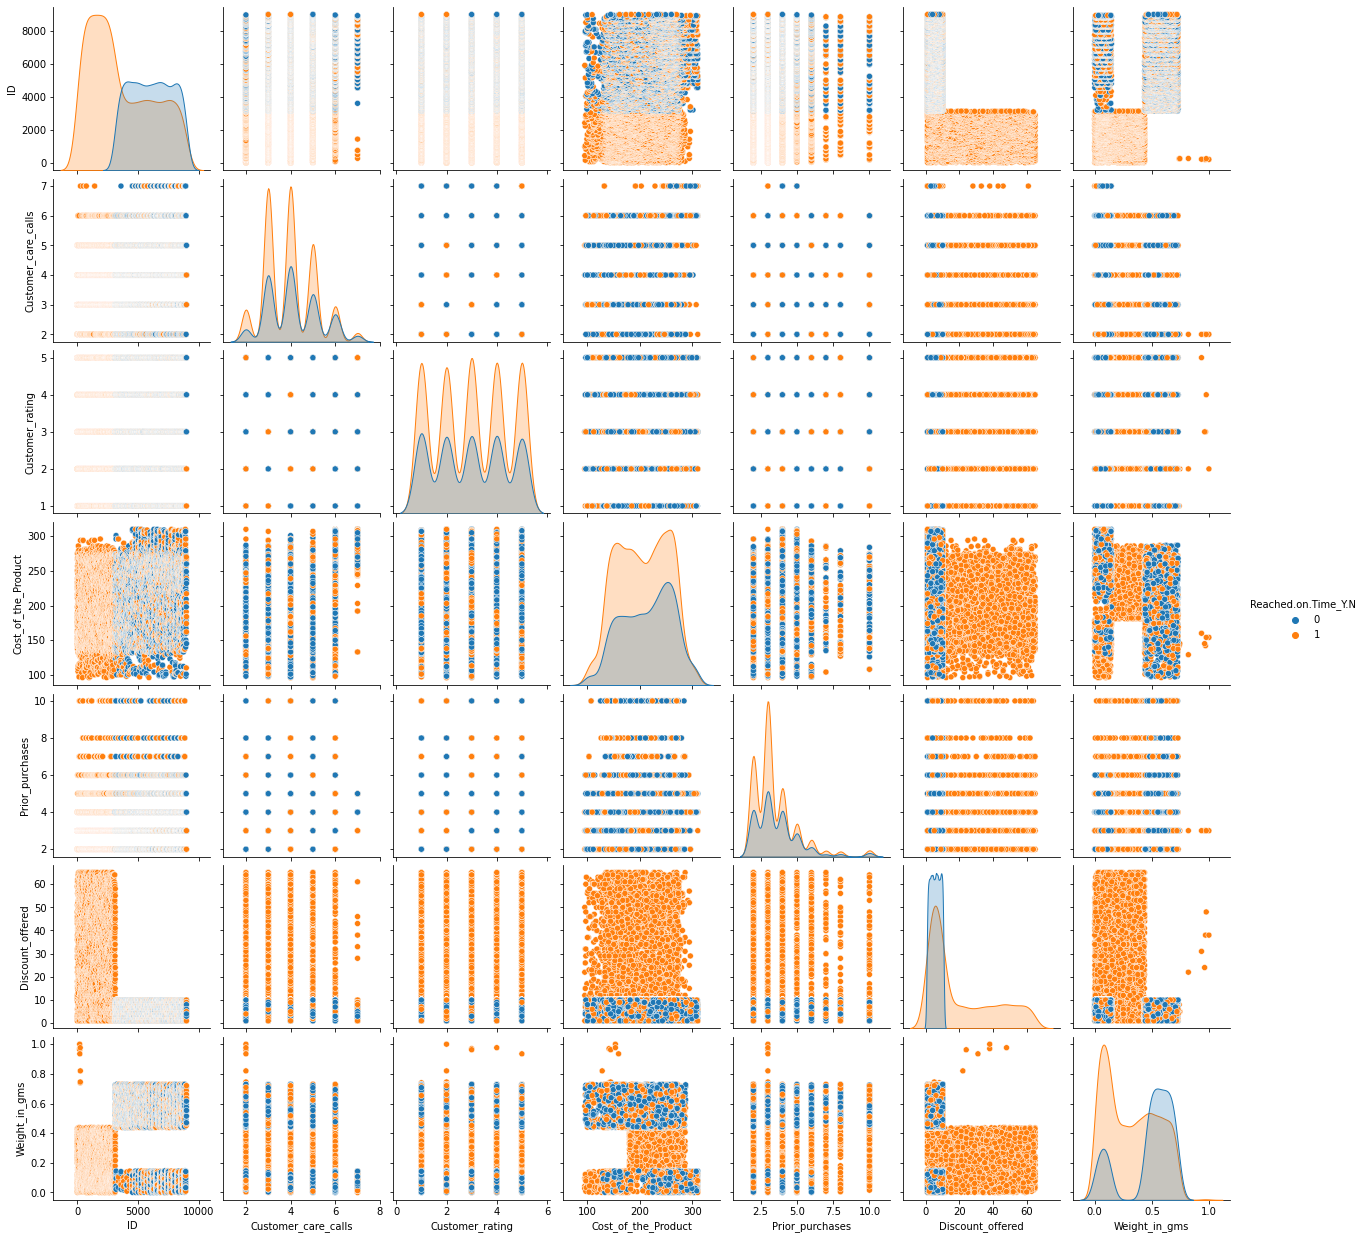

In [41]:
sns.pairplot(df_train, hue= 'Reached.on.Time_Y.N')
plt.show()

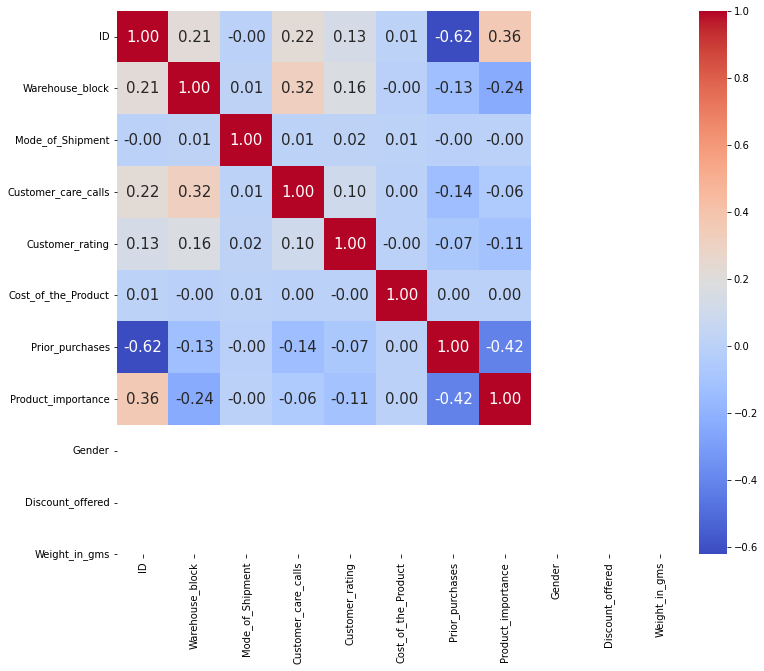

In [58]:
corr = df_train.drop(columns = ['Reached.on.Time_Y.N']).corr(method='pearson')
plt.figure(figsize=(14,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_train.drop(columns = ['Reached.on.Time_Y.N']).columns, 
           yticklabels= df_train.drop(columns = ['Reached.on.Time_Y.N']).columns,
           cmap= 'coolwarm')

plt.show()

Elegimos Producto_importance para decodificar ya que intuitivamente creo que puede tener inferencia en la entrega. Y elegimos ademas Weight_in_gms y Discount_offered ya que segun los graficos podemos ver que pueden ser buenos predictores.

In [42]:
df_train['Product_importance'].value_counts()

low       4308
medium    3858
high       833
Name: Product_importance, dtype: int64

In [45]:
label_encoder = preprocessing.LabelEncoder()
df_train['Product_importance'] = label_encoder.fit_transform(df_train['Product_importance'])

In [46]:
df_train['Product_importance'].value_counts()

1    4308
2    3858
0     833
Name: Product_importance, dtype: int64

In [76]:
#Agregamos el label encoder a Warehouse_block y a Mode_of_Shipment.
df_train['Warehouse_block'] = label_encoder.fit_transform(df_train['Warehouse_block'])
df_train['Mode_of_Shipment'] = label_encoder.fit_transform(df_train['Mode_of_Shipment'])

In [93]:
columnasEntrenamiento =['Warehouse_block','Mode_of_Shipment','Customer_care_calls','Customer_rating','Cost_of_the_Product','Prior_purchases', 'Product_importance', 'Discount_offered', 'Weight_in_gms']
X = df_train[columnasEntrenamiento].to_numpy()
y = df_train['Reached.on.Time_Y.N'].to_numpy()

In [94]:
#Dividimos nuestro set en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [107]:
#Consideramos el modelo de arbol de decision para predecir. Instanciamos.
tree = DecisionTreeClassifier(max_depth=14)

In [108]:
#Entrenamos
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=14)

In [109]:
# Predecimos sobre nuestro set de entrenamieto

y_train_pred = tree.predict(X_train)

# Predecimos sobre nuestro set de testeo

y_test_pred = tree.predict(X_test)

In [110]:
#Matriz de confusion
matrix = confusion_matrix(y_train, y_train_pred)
matrix

array([[2348,  253],
       [1045, 3553]], dtype=int64)

In [111]:
#Calculamos accuracy
exactitud = accuracy_score(y_test, y_test_pred)
print(exactitud)

0.6983333333333334


In [112]:
#Calculamos recall
precision = recall_score(y_train, y_train_pred)
precision


0.7727272727272727

El modelo no dio un resultado que esperaba(R = 0.68) asi que fui modificando dimensiones e hiperparametro de profundidad del arbol para lograr un recall mas alto.

Pasamos a predecir el dataset de testeo

In [116]:
df_test.drop(['Gender'], axis= 1, inplace= True)

In [114]:
df_test['Product_importance'] = label_encoder.fit_transform(df_test['Product_importance'])
df_test['Warehouse_block'] = label_encoder.fit_transform(df_test['Warehouse_block'])
df_test['Mode_of_Shipment'] = label_encoder.fit_transform(df_test['Mode_of_Shipment'])

In [117]:
df_test

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms
0,9000,4,2,5,1,189,2,2,10,5248
1,9001,3,2,5,3,150,2,0,9,4446
2,9002,4,2,3,3,200,3,1,3,5739
3,9003,0,2,5,1,133,2,2,1,4643
4,9004,1,2,4,2,260,3,1,4,5504
...,...,...,...,...,...,...,...,...,...,...
1995,10995,0,2,4,1,252,5,2,1,1538
1996,10996,1,2,4,1,232,5,2,6,1247
1997,10997,2,2,5,4,242,5,1,4,1155
1998,10998,4,2,5,2,223,6,2,2,1210


In [119]:
#Instanciamos los fiutures a considerar
columnasTesteo =['Warehouse_block','Mode_of_Shipment','Customer_care_calls','Customer_rating','Cost_of_the_Product','Prior_purchases', 'Product_importance', 'Discount_offered', 'Weight_in_gms']
X_test = df_test[columnasEntrenamiento].to_numpy()


In [120]:
#Predecimos
resultado = tree.predict(X_test)


In [121]:
respuesta = pd.DataFrame(resultado, columns=['pred'])

In [123]:
respuesta.to_csv('MateoEmma.csv', index= False)